# Optimized EGARCH(p,q) model Python Code
## Sector Volatility Prediction Performance using GARCH Models and Artificial Neural Networks
## MSc Thesis
## Curtis Nybo, 2020
### Version: 3.0

My MSc Dissertation paper results for the GARCH section are derived using this notebook.

I mainly utilize the works of Kenneth R. French for the datasets, Auquan, and Sarit Maitra.

# Loading Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
formatter = DateFormatter('%Y')
import os

import scipy.stats as stats
from scipy.stats import skew
from scipy.stats import kurtosis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

import datetime as dt
import sys
from arch import arch_model

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from statsmodels.tsa.stattools import adfuller
from arch.univariate import ARX

import math
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

# Controls (Choose the sector data and file location)

In [2]:
#Sector to be analyzed - This value can be changed between Technology, Consumer Durables, Health, Manufacturing, Other.
sector = 'Other'
#Working Directory
os.chdir('C:\\Users\\CurtisXPS\\OneDrive\\School\\MSc Finance\\Dissertation')

In [3]:
# Train and Test set criteria
train_rng_start = 0 # These values are NOT dates, they are positions in the dataset index
train_rng_end = 3086 # Range ends at but doesn't include this date (first date from test set)
train_rng_len = 3086
test_rng_len = 772
test_rng_start = train_rng_end
test_date_start = '2017-04-06'

#Lags
lag_ = 12

# Crunching and cleaning the data

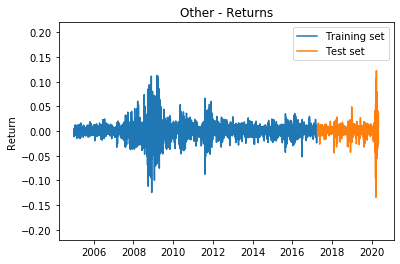

In [4]:
rawdata = pd.read_csv('Data\\Ken F - Five Sector\\' + sector + '.csv')
rawdata['Date'] = pd.to_datetime(rawdata['Date'])
rawdata = rawdata.set_index(['Date'])
train_data = rawdata[train_rng_start:train_rng_end]
test_data = rawdata[train_rng_end:]

# Return Plot
plt.plot(train_data, label='Training set')
plt.plot(test_data, label='Test set')
plt.title(sector + ' - Returns')
plt.legend(loc='best')
plt.ylim(-0.22, 0.22)
plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
plt.ylabel('Return')
#plt.savefig('Thesis Document\\KF5 Figures\\Optimized GARCH\\' + sector + '\\' + sector + '_close_price.png')
plt.show()

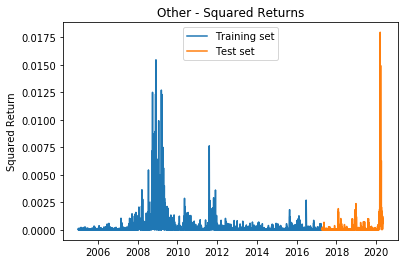

In [5]:
# Producing the variables we need

train_data['Squared Return'] = train_data['Returns']**2
train_sq_returns = train_data['Squared Return']
train_returns = train_data['Returns']

test_data['Squared Return'] = test_data['Returns']**2
test_sq_returns = test_data['Squared Return']
test_returns = test_data['Returns']

plt.plot(train_sq_returns, label='Training set')
plt.plot(test_sq_returns, label='Test set')
plt.title(sector + ' - Squared Returns')
plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
plt.legend(loc='best')
#plt.ylim([-0.001,0.04])
plt.ylabel('Squared Return')
#plt.savefig('Thesis Document\\KF5 Figures\\Optimized GARCH\\' + sector + '\\' + sector + '_log_returns.png')
plt.show()

In [6]:
# Produce a histogram if needed

# plt.hist(log_returns, bins=100)
# plt.title(sector + ' Return Distribution')
# plt.ylabel('Frequency')
# plt.xlabel('Returns')
# plt.savefig('Thesis Document\\Optimized GARCH Figures\\' + sector + '\\' + sector + '_return_dist.png')
# plt.show()

# Initial Descriptive Statistics for the datatset

Uses JB stat, Q statistics, and ADF test. See paper for details. 

In [7]:
desc_JB = sm.stats.stattools.jarque_bera(train_returns)
desc_JB_s = desc_JB[0]
desc_JB_p = desc_JB[1]

desc_Q_f = sm.stats.acorr_ljungbox(train_returns, lags=[lag_], return_df=True)
desc_Q_s = desc_Q_f.lb_stat.iloc[0]
desc_Q_p = desc_Q_f.lb_pvalue.iloc[0]

desc_Q2_f = sm.stats.acorr_ljungbox(train_sq_returns, lags=[lag_], return_df=True)
desc_Q2_s = desc_Q2_f.lb_stat.iloc[0]
desc_Q2_p = desc_Q2_f.lb_pvalue.iloc[0]

desc_adf = sm.tsa.stattools.adfuller(train_returns)
desc_adf_s = desc_adf[0]
desc_adf_p = desc_adf[1]

print ('JB: {:.5f} , {:.5f} | Q stat: {:.5f} , {:.5} | Q2 stat: {:.5f} , {:.5f} | ADF: {:.5f} , {:.5f}'.format(desc_JB_s, 
desc_JB_p, desc_Q_s, desc_Q_p, desc_Q2_s, desc_Q2_p, desc_adf_s, desc_adf_p))


JB: 12562.42463 , 0.00000 | Q stat: 60.42908 , 1.8851e-08 | Q2 stat: 3355.47642 , 0.00000 | ADF: -11.01439 , 0.00000


# GARCH model optimal specification algorithm
This algorithm will find the optimal GARCH(p,q) model based on the lowest AIC value that results in white noise residuals. 

Leveraging the work of Auquan (2)

In [8]:
def get_best_garch(data):
    best_qstat = 0
    best_order = None
    best_aic = np.inf

    p_rng = [1,2,3,4,5]
    q_rng = [1,2,3,4,5]
    for p_ in p_rng:
        for q_ in q_rng:
            try:
                tmp_model = arch_model(data, mean="Constant", vol='EGARCH', p=p_, o=1, q=q_).fit(disp='off')
                tmp_qstat = sm.stats.acorr_ljungbox(tmp_model.std_resid**2, lags=[lag_], return_df=True).lb_pvalue
                tmp_qstat2 = sm.stats.acorr_ljungbox(tmp_model.std_resid, lags=[lag_], return_df=True).lb_pvalue
                tmp_aic = tmp_model.aic
                if tmp_qstat2.iloc[0] > 0.01 and tmp_aic < best_aic and tmp_qstat.iloc[0] > 0.01:
                    best_qstat = tmp_qstat.iloc[0]
                    best_order = (p_, q_)
                    best_aic = tmp_aic
            except: continue

    #print('qstat: {:.5f} | order: {} | AIC: {:.5f}'.format(best_qstat, best_order, best_aic))
    return best_qstat, best_order, best_aic


best_garch = get_best_garch(train_returns)

## This is the result of the GARCH(p,q) finder

In [9]:
print('Best Model: {} | AIC: {:.5f} | Q-stat_sqresid: {:.5f}'.format(best_garch[1], best_garch[2], best_garch[0]))

Best Model: (3, 1) | AIC: -18916.06020 | Q-stat_sqresid: 0.19453


# Running the GARCH model with the found paramters from above cell

In [10]:
# Choose the proper p and q specs from the 'Best Model' results of the algorithm
p_ = 3
o_ = 1 # This value stays as 0, unless using an EGARCH model
q_ = 1

# Using student T distribution usually provides better fit
am = arch_model(train_returns, mean="Constant", vol='EGARCH', p=p_, o=o_, q=q_)
res = am.fit(disp='off')
#print(res.summary())
print(res)

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                Returns   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                     EGARCH   Log-Likelihood:                9465.03
Distribution:                  Normal   AIC:                          -18916.1
Method:            Maximum Likelihood   BIC:                          -18873.8
                                        No. Observations:                 3086
Date:                Wed, Sep 30 2020   Df Residuals:                     3079
Time:                        11:02:12   Df Model:                            7
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         3.2946e-04  1.672e-04      1.971  4.874e-02 [1.

# Checking for white noise residuals

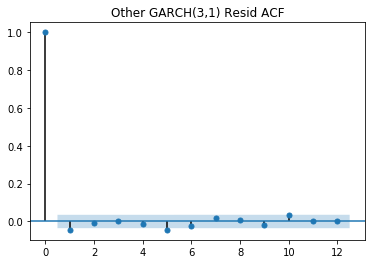

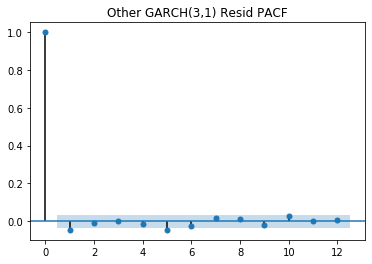

,lb_stat,lb_pvalue
12,20.837464,0.052812


In [11]:
plot_acf(res.std_resid, lags=lag_, title=("{sector} GARCH({p_},{q_}) Resid ACF".format(sector=sector, p_=p_, q_=q_)))
#plt.savefig('Thesis Document\\KF5 Figures\\Optimized GARCH\\' + sector + '\\' + sector + '_resid_acf.png')
plot_pacf(res.std_resid, lags=lag_, title=("{sector} GARCH({p_},{q_}) Resid PACF".format(sector=sector, p_=p_, q_=q_)))
#plt.savefig('Thesis Document\\KF5 Figures\\Optimized GARCH\\' + sector + '\\' + sector + '_resid_pacf.png')
plt.show()
plt.close()
sm.stats.acorr_ljungbox(res.std_resid, lags=[lag_], return_df=True)

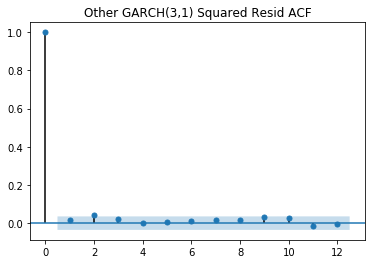

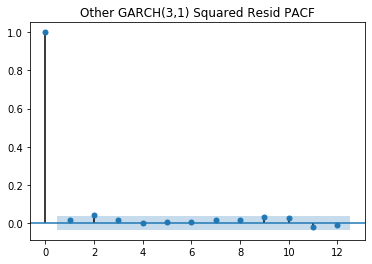

,lb_stat,lb_pvalue
12,15.92859,0.194529


In [12]:
plot_acf(res.std_resid**2, lags=lag_, title=("{sector} GARCH({p_},{q_}) Squared Resid ACF".format(sector=sector, p_=p_, q_=q_)))
#plt.savefig('Thesis Document\\KF5 Figures\\Optimized GARCH\\' + sector + '\\' + sector + '_resid_2_acf.png')
plot_pacf(res.std_resid**2, lags=lag_, title=("{sector} GARCH({p_},{q_}) Squared Resid PACF".format(sector=sector, p_=p_, q_=q_)))
#plt.savefig('Thesis Document\\KF5 Figures\\Optimized GARCH\\' + sector + '\\' + sector + '_resid_2_pacf.png')
plt.show()
plt.close()
sm.stats.acorr_ljungbox(res.std_resid**2, lags=[lag_], return_df=True)

# Forecasting using the above GARCH specification
This section provides the forecast given the above specs that were used in the GARCH validation.

## Reloading the test data and GARCH Model with above (p,q) specs

In [13]:
## Weekly data from 01-02-2002 to 12-30-2019
sector_data_fcst = pd.read_csv('Data\\Ken F - Five Sector\\' + sector + '.csv')
sector_data_fcst['Date'] = pd.to_datetime(sector_data_fcst['Date'])

sector_data_fcst = sector_data_fcst.set_index('Date')

sector_data_fcst = sector_data_fcst[train_rng_start:] #Drop NA on the first line

## Other Data Series Subsets
log_returns_fcst = sector_data_fcst['Returns']
sector_data_fcst['Squared Returns'] = sector_data_fcst['Returns']**2
squared_log_returns_fcst = sector_data_fcst['Squared Returns']

## Refitting the model

In [14]:
am_fcst = arch_model(log_returns_fcst, mean="Constant", vol='EGARCH', p=p_, o=o_, q=q_)

## Producing the rolling-window forecast for one week ahead with out-of-sample data

Using the rolling window code from the ARCH library documentation (1)

In [15]:
## Rolling window forecast
index = log_returns_fcst.index
start_loc = 0
end_loc = np.where(index >= test_date_start)[0].min()
forecasts = {}
for i in range(test_rng_len):
    sys.stdout.write('.')
    sys.stdout.flush()
    res_fcst = am_fcst.fit(first_obs=i, last_obs=i + end_loc, disp='off')
    temp = res_fcst.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print()
print(pd.DataFrame(forecasts).T)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
                 h.1
2017-04-05  0.000079
2017-04-06  0.000077
2017-04-07  0.000076
2017-04-10  0.000069
2017-04-11  0.000062
...              ...
2020-04-23  0.000767
2020-04-24  0.000632
2020-04-27  0.000570
2020-04-28  0.000

In [16]:
# Reformatting the data - The date shown in the above result is the final date used in the forecast
# This cell pushes the date out one day to be plotted for the +1 day ahead forecast
forecast_final = (pd.DataFrame(forecasts).T)
forecast_final.index = forecast_final.index.shift(1, freq='B') 
print(forecast_final)

                 h.1
2017-04-06  0.000079
2017-04-07  0.000077
2017-04-10  0.000076
2017-04-11  0.000069
2017-04-12  0.000062
...              ...
2020-04-24  0.000767
2020-04-27  0.000632
2020-04-28  0.000570
2020-04-29  0.000527
2020-04-30  0.000438

[772 rows x 1 columns]


# Visualizing the forecasted volatility values

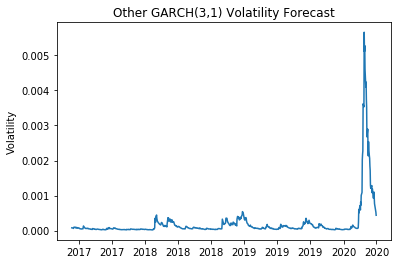

In [17]:
plt.plot(forecast_final)
plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
plt.title("{sector} GARCH({p_},{q_}) Volatility Forecast".format(sector=sector, p_=p_, q_=q_))
plt.ylabel('Volatility')
#plt.savefig('Thesis Document\\KF5 Figures\\Optimized GARCH\\' + sector + '\\' + sector + '_vol_fcst_value.png')
plt.show()

## Overlaying the forecasted volatility values against the true squared returns in the out-of-sample data

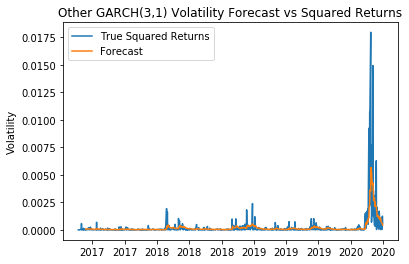

In [18]:
plt.plot(squared_log_returns_fcst.iloc[(train_rng_len - 20):], label="True Squared Returns")
plt.plot(forecast_final, label="Forecast")
plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
plt.title("{sector} GARCH({p_},{q_}) Volatility Forecast vs Squared Returns".format(sector=sector, p_=p_, q_=q_))
plt.ylabel('Volatility')
plt.legend(loc='best')
#plt.savefig('Thesis Document\\KF5 Figures\\Optimized GARCH\\' + sector + '\\' + sector + '_full_volatility_fcst.png')
plt.show()

# Forecast Performance
Producing the performance metrics (MAE, MAPE, RMSE)

In [19]:
test_set = pd.DataFrame(squared_log_returns_fcst[train_rng_len:])

testMAE = mean_absolute_error(test_set, forecast_final)
print('%.7f MAE | ' % (testMAE))

testRMSE = math.sqrt(mean_squared_error(test_set, forecast_final))
testMSE = testRMSE**2
print('%.7f MSE | ' % (testMSE))
print('%.7f RMSE | ' % (testRMSE))

0.0002231 MAE | 
0.0000008 MSE | 
0.0009217 RMSE | 


# References

(1) Kevin Sheppard, Stanislav Khrapov, Gábor Lipták, mikedeltalima, Rob Capellini, esvhd, … jbrockmendel. (2019, November 22). bashtage/arch: Release 4.13 (Version 4.13). Zenodo. http://doi.org/10.5281/zenodo.3551028

(2) Auquan - Time Series Analysis for Financial Data VI— GARCH model and predicting SPX returns - https://medium.com/auquan/time-series-analysis-for-finance-arch-garch-models-822f87f1d755 - 2017

(3) Sarit Maitra - Forecasting using GARCH Processes & Monte-Carlo Simulations: statistical analysis & mathematical model using Python - https://towardsdatascience.com/garch-processes-monte-carlo-simulations-for-analytical-forecast-27edf77b2787 - 2019

(4) Data Library - Kenneth R. French - https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html - 2020